### Week 3: Real Time Data, Understanding Orders, and Arbitrage

Todo: talk about websockets.

Todo: talk about order types (market, limit, stop loss). 

Todo: talk about quotes (bid-ask spread, order size).

In [5]:
from config import *
import websocket
import json
import numpy as np

SOCKET_ENDPOINT = "wss://data.alpaca.markets/stream"
STOCKS = ["T.AAPL"]  
# T. is trades (ie all trades executed by exchanges)  Q. is quotes (what people are willing to buy/sell for)

In [6]:
# all websockets take 3 mandatory functions: on open, on message, and on close.  
# On open gets called once when we try to connect 
# on message gets called each time we get a new piece of data sent to us
# on close gets called when we close the connection (stop listening to data)


def on_open(ws):
    # we have to send an authentication message
    auth_data = {
        "action": "authenticate",
        "data": {
            "key_id": f"{KEY}",
            "secret_key": f"{SECRET_KEY}"
        }
    }
    # authenticate our connection
    ws.send(json.dumps(auth_data))

    channel_data = {
        "action": "listen",
        "data": {"streams": STOCKS}  # streams is what channels we want to subscribe to
    }

    ws.send(json.dumps(channel_data))
    
    
def on_message(ws, message):
    # every time a message gets sent to us we have to define what to do.  In this instance we'll just print it
    # but we can get more complex by doing stuff like analyzing the high frequency data to make orders
    print("received a message")
    print(message)
    
def on_close(ws):
    print("closed connection")

In [8]:
ws = websocket.WebSocketApp(SOCKET_ENDPOINT, on_open=on_open, on_message=on_message, on_close=on_close)
# you'll want to run this in a local terminal for it to work
ws.run_forever()

received a message
{"stream":"authorization","data":{"action":"authenticate","status":"unauthorized"}}
received a message
{"stream":"authorization","data":{"action":"listen","status":"unauthorized"}}
closed connection


True

### I saved some of this raw data I collected into a csv file, now let's analyze it
I ran this for maybe 30 minutes.  As you can see we get a ton of data when we're operating on the tick frequency

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

spyData = pd.read_csv("spy.csv")
# if you don't know SPY is an index fund comprised of the S&P 500 companies, so it's generally a good 
# indicator of general market performance on the long term

In [15]:
spyData
# columns are as follows: ticker, bid exchange, bid size (in hundreds), ask exchange, ask price, ask size, unix time

,T,x,p,s,X,P,S,t
0,SPY,17,371.89,1,17,371.90,1,1608230445386000000
1,SPY,17,371.89,1,17,371.90,2,1608230445824000000
2,SPY,2,371.88,3,17,371.90,2,1608230444935000000
3,SPY,17,371.88,2,17,371.90,2,1608230446176000000
4,SPY,2,371.88,3,17,371.90,2,1608230446489000000
...,...,...,...,...,...,...,...,...
12442,SPY,15,372.00,1,17,372.01,1,1608231151507000000
12443,SPY,15,372.00,1,9,372.01,1,1608231151507000000
12444,SPY,15,372.00,1,2,372.01,1,1608231151507000000
12445,SPY,15,372.00,1,17,372.01,1,1608231151507000000


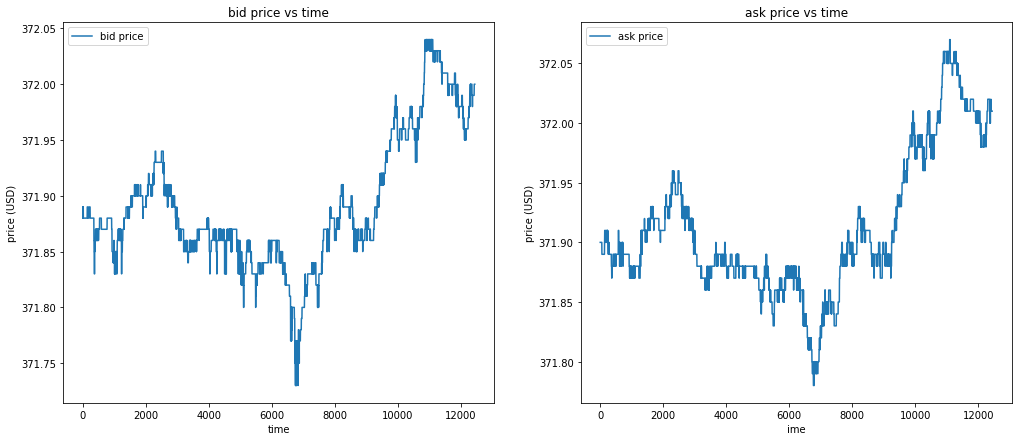

In [30]:
# let's first see how bid and ask price changes over this interval
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,7))
ax1.plot(spyData["p"], label="bid price")
ax1.set_xlabel("time")
ax1.set_ylabel("price (USD)")
ax1.set_title("bid price vs time")
ax1.legend()

ax2.plot(spyData["P"], label="ask price")
ax2.set_xlabel("ime")
ax2.set_ylabel("price (USD)")
ax2.set_title("ask price vs time")
ax2.legend()
plt.show()

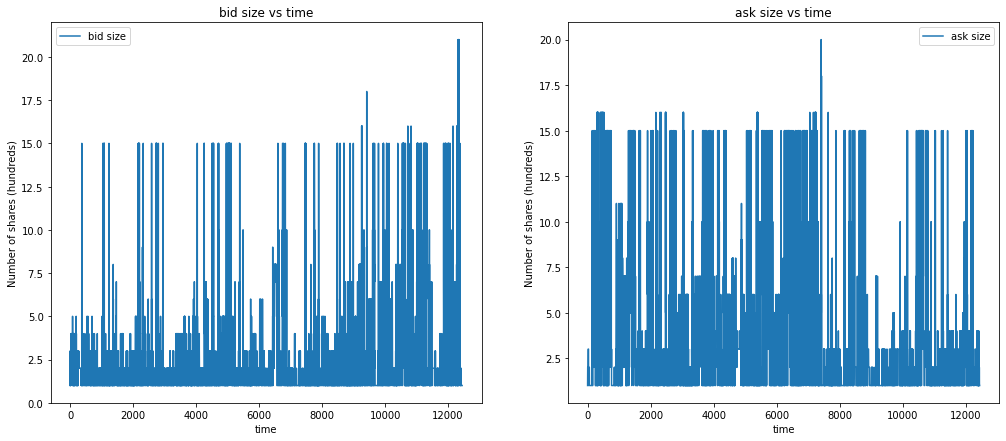

In [29]:
# another obvious one to look at is bid and ask.
# As a quant we might believe there is some correllation between the
# number of shares being traded and a quick dip or gain in the price

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,7))
ax1.plot(spyData["s"], label="bid size")
ax1.set_xlabel("time")
ax1.set_ylabel("Number of shares (hundreds)")
ax1.set_title("bid size vs time")
ax1.legend()

ax2.plot(spyData["S"], label="ask size")
ax2.set_xlabel("time")
ax2.set_ylabel("Number of shares (hundreds)")
ax2.set_title("ask size vs time")
ax2.legend()
plt.show()

### Lets think about this data

What first strikes me is the change of "density" in the bid and ask size.  From the 8-12k time mark in the bid size we see a general increase in the number of shares being purchased (more blue) (we'll call this bid density), whereas in the 2-6k time mark in the ask size we see a general increase in the number of shares being sold (we'll call this ask desity).  

The interesting thing is that the increase in bid density correlates with an increase in bid and ask price (around 15 cents), whereas the increasing ask density correlates with a decrease in bid and ask price (around 20 cents).

Now this is only one example on a small portion of data, but with a bit of work we could easily turn this into a trading strategy where we buy or sell positions in SPY based on noticing whether this bid/ask density exhibits strong changes.  We could even test this out on different stocks.  SPY generally is not very volatile, but we could get bigger returns for bigger risk with more volatile assets.  

Analyzing data and noticing patterns is the name of the game in quant world.  The next step would be to make some sort of mathematical definition of this bid ask density so we can calculate it and correctly identify whether we want to enter or exit a position in a trading algorithm and test our results.

### So what do we do with this data?

Answer: By getting data almost instantly (10ish milliseconds latency - but this will differ by location) from exchanges, we're among the first people in the markets to know what people are doing.  

Here are three key strategies that "high frequency traders" use to make money.  We'll illustrate them with examples then get a bit more technical.  

### Market Making: 
Say you go to a farmer's market and want to buy some apples.  You see that farmers are selling apples for 1.00 (bid price) a piece, but suppose you heard people waiting in line to get in saying they're willing to buy apples for 1.05 (ask price) a piece.  With this information, you run ahead of everyone else and buy the apples for they're market price of 1.00 then run back to the people in line and sell your apples for 1.05 a piece.  In essense you are able to act faster than everyone else and use that to your advantage.  By doing so you're rewarded with a risk-free(ish) profit of 5 cents a peice

In the real market scenario, you have algorithms watching quotes from exchanges and if there is a sufficiently large bid ask spread, you'll purchase the shares for the bid price then immediately sell them at the ask price, being rewarded with the spread.  The issue here is that if someone sells the shares to that third person faster than you, then you've got shares you don't want to have and no one to buy them from you.

### Arbitrage: 
Say you are at the same farmers market and can purchase apples for 1.00 a piece, but you know there's another famers market across town with people buying apples at 1.20 a peice.  You purchase the apples, drive across town, then dump your apples.

In a trading scenario, you can purchase shares of Apple stock at various stock exchanges, say NYSE and Hong Kong Stock Exchange.  We would expect these prices to be very close, but occasionally the price may differ by more than a few cents.  Then we can purchase shares at the cheeper exchange then sell them at the more expensive exchange and pocket the spread. 

### Trade Following (more falls into statarb):
I can't think of a good example for this, so we'll go straight into the market example.  

Say we're watching trade streams from an exchange and notice that a huge amount of shares are trying to be sold, which might be a big bank liquidating their position.  We believe that this liquidation will cause a quick dip in share price (higher supply, same demand), so we quickly short the stock and hope the price does what we want.

### We'll code up a quick market maker algo

In [9]:
import json
from setup_requests import make_order
# the idea here is that we'll watch quote streams then try to buy at the bid price and sell at the ask price


def analyze(ws, message):
    json_dict = json.loads(message)
    quote = json_dict["data"]
    if quote["ev"] == "Q":
        asset = quote["T"]
        bid_price = quote["p"]
        bid_size = quote["s"]
        ask_price = quote["P"]
        ask_size = quote["S"]
        # naive approach: buy if bid-ask spread > $.03

        spread = quote["P"] - quote["p"]
        # we want a reasonably large spread so we make good money for the risk
        if spread >= .05 and bid_size > ask_size:
            order_size = 1
            buy_order = make_order(asset, order_size, "buy", "limit", "fok", ask_price)
            if buy_order["status"] == "accepted":
                print(f"bought {order_size} of {asset} at {bid_price}")
                sell_order = make_order(asset, order_size, "sell", "limit", "fok", bid_price)
                if sell_order["status"] == "accepted":
                    print(f"sold {order_size} of {asset} at {ask_price}")

Now to test this out, we just make a quick change to our websocket.

In [10]:
def on_open(ws):
    # we have to send an authentication message
    auth_data = {
        "action": "authenticate",
        "data": {
            "key_id": f"{KEY}",
            "secret_key": f"{SECRET_KEY}"
        }
    }
    # authenticate our connection
    ws.send(json.dumps(auth_data))

    channel_data = {
        "action": "listen",
        "data": {"streams": STOCKS}  # streams is what channels we want to subscribe to
    }

    ws.send(json.dumps(channel_data))
    
    
def on_message(ws, message):
    analyze(ws, message)
    
def on_close(ws):
    print("closed connection")

In [11]:
ws = websocket.WebSocketApp(SOCKET_ENDPOINT, on_open=on_open, on_message=on_message, on_close=on_close)
ws.run_forever()

closed connection


True

Now when this runs we notice that we very rarely got orders filled.  We correctly identified when to purchase orders, but by the time our order was processed by the exchange there were no longer anymore shares to be purhcased near the bid price.  This means that we were simply too slow.

And this is basically as far as you can get with market making as a retail trader.  We're operating on the millisecond latency scale, but high frequency trading firms operate on the nanosecond scale, meaning they're roughly a million times faster than we are.  This basically means that they place servers to run their code literally across the street from places like the NYSE or sometimes even inside the exchanges themselves, and with all this infastructure there is almost no chance you'll beat a high frequency trader to the exchange.  

Speedups also come from code.  Python is notoriously slow, meaning that quants oftentimes test ideas and benchmark them in python since it's easy to use, but production algotrading code is almost entirely written in C or C++, and sometimes Assembley to get the fastest code.  

Same is true for arbitrage, which is free money if you have fast enough computers.